In [2]:
import pandas as pd
import numpy as np
import numpy.random as nrand
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [66]:
# Load and preprocess phenotype data
phe_df_raw = pd.read_table('/home/siliang/Public/workspace/4_UKB_merged_files/GWAS/GWAS_adj_extended.phe')
phe_df_raw = phe_df_raw[['IID','Sex_merged','N_full_brothers','N_full_sisters']]
_idx = phe_df_raw[['N_full_brothers','N_full_sisters']].isna().sum(axis=1) > 0
phe_df_raw.loc[_idx,['N_full_brothers','N_full_sisters']] = 0
phe_df_raw['N'] = phe_df_raw[['N_full_brothers','N_full_sisters']].sum(axis=1)
phe_df_raw['SR'] = phe_df_raw['N_full_brothers']/phe_df_raw['N']

In [4]:
# Load and relatedness data
relatedness_df = pd.read_table('../Family-based_heritability/relatedness_pairs.tsv')

# ID1: Individual ID for the first individual of the pair
# ID2: Individual ID for the second individual of the pair
# HetHet: Proportion of SNPs with double heterozygotes (e.g., AG and AG)
# IBS0: Fraction of markers for which the pair shares zero alleles (output from KING software).
# Kinship: Estimate of the kinship coefficient for this pair based on the set of markers used in the 
#          kinship inference (output from KING software).
# class: classified groups of relatives. 
#        0: MZ twins; 1: parent-offspring pairs; 2: full siblings; 3: second degree ralative pairs; 
#        4: third degree relative pairs; -1: unclassified
# isEuro: True if the both individuals have European ancestry; False if not.


In [ ]:
# Add sex ratio information of the first individual of the relative pair (ID1) to relatedness_df
relatedness_df = pd.merge(right=phe_df_raw[['IID','N_full_brothers','N_full_sisters']], left=relatedness_df, left_on='ID1', right_on='IID')
relatedness_df = relatedness_df.drop(columns='IID')
assert (phe_df_raw[['N_full_brothers','N_full_sisters']].sum(axis=1)<0).sum() == 0
relatedness_df['SR_ID1'] = phe_df_raw['N_full_brothers']/phe_df_raw[['N_full_brothers','N_full_sisters']].sum(axis=1)
relatedness_df = relatedness_df.drop(columns=['N_full_brothers','N_full_sisters'])

# Add sex ratio information of the first individual of the relative pair (ID1) to relatedness_df
relatedness_df = pd.merge(right=phe_df_raw[['IID','N_full_brothers','N_full_sisters']], left=relatedness_df, left_on='ID2', right_on='IID')
relatedness_df = relatedness_df.drop(columns='IID')
assert (phe_df_raw[['N_full_brothers','N_full_sisters']].sum(axis=1)<0).sum() == 0
relatedness_df['SR_ID2'] = phe_df_raw['N_full_brothers']/phe_df_raw[['N_full_brothers','N_full_sisters']].sum(axis=1)
relatedness_df = relatedness_df.drop(columns=['N_full_brothers','N_full_sisters'])

relatedness_df = relatedness_df.dropna(subset=['SR_ID1','SR_ID2'])

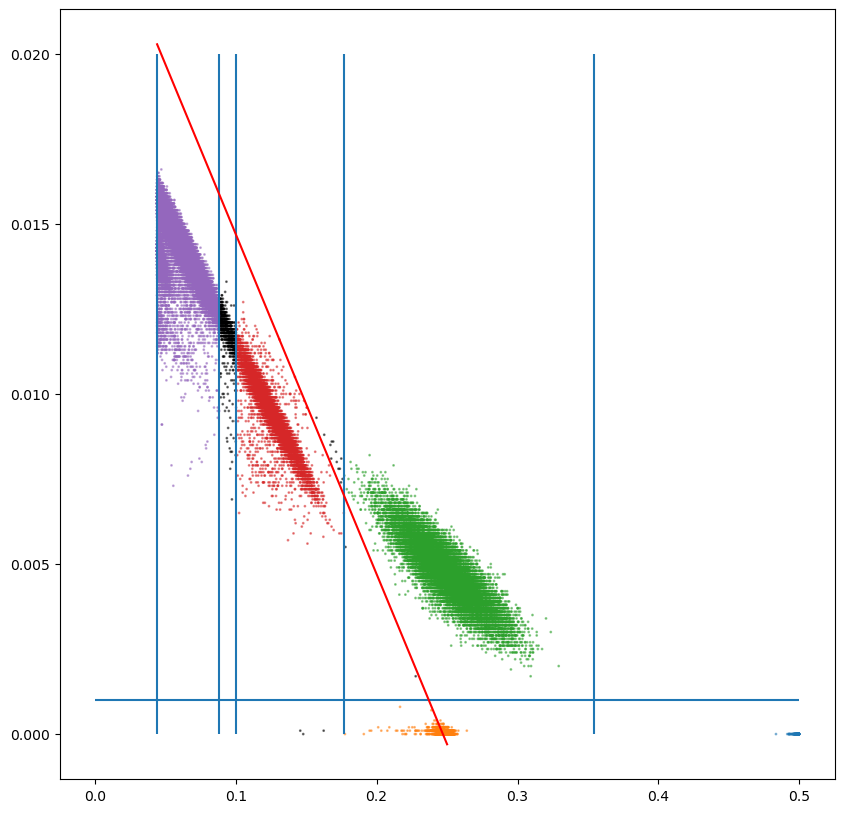

In [5]:
# Set color list based on class
color_list = []
for i in relatedness_df['class']:
    if i != -1:
        color_list.append(f'C{i}')
    else:
        color_list.append(f'k')

# Plot kinship vs IBS0
plt.subplots(figsize=[10,10])
plt.scatter(x='Kinship',y='IBS0',data=relatedness_df,alpha=0.5,s=1,color=color_list)
plt.vlines(x=[0.0442,0.0884,0.1,0.177,0.354],ymin=0, ymax=0.02)
plt.hlines(y=0.001,xmin=0, xmax=0.5)

x = np.array([0.0442,0.25])
y = x*(-0.1)+0.0247
plt.plot(x,y,'r-')

In [73]:
# Example script to analyze the heritability of SSB among females.
# Note that only 1st, 2nd, and 3rd degree relative pairs are used in this specific case due to 
# the lack of MZ twins datapoints. Generally, one should use twins, 1st, 2nd, and 3rd degree relative 
# pairs to do the analysis.

# Filter relatedness data
idx_filter = relatedness_df['SR_ID1'].notna() & relatedness_df['SR_ID2'].notna() & relatedness_df['isEuro']

# Pearson correlation coefficient calculation
PCC_dict = {}
for K in [1,3,4]: # 0: twins; 1: first degree realtives; 3: second degree relatives; 4: third degree relatives
    if K != 1:
        idx = (relatedness_df['class'] == K) & idx_filter
    elif K == 1:
        idx = (relatedness_df['class'] == 1) & idx_filter # not using siblings (relatedness_df['class']==2)
        
    r_list=[]
    sub_df = relatedness_df[idx]
    i=0
    
    # bootstrap 10000 times and calculate correlation between relative pairs in terms of their sibling sex ratio
    while i < 10000:
        if i % 100 == 0:
            print(i,flush=True, end='\r')
        bs_df = sub_df.sample(n=len(sub_df),replace=True)
        r,p = stats.pearsonr(bs_df['SR_ID1'],bs_df['SR_ID2'])
        if np.isnan(r):
            continue
        i += 1
        r_list.append(r)
    PCC_dict[K] = r_list

In [74]:
# Heritability calculation
h2_list = []
P_list = []
intercept = []

for i in range(10000):
    X = [0.5,0.25,0.125]
    X = sm.add_constant(X, prepend=False)
    Y = [PCC_dict[1][i],PCC_dict[3][i],PCC_dict[4][i]]
    mod = sm.OLS(Y, X)
    res = mod.fit()
    h2_list.append(res.params[0])
    intercept.append(res.params[1])
    P_list.append(res.pvalues[0])

In [75]:
print(f"Heritability: {np.mean(h2_list)}")
print(f"Heritability std: {np.std(h2_list)}")
print(f"Heritability 95% CI: {np.percentile(h2_list,q=[2.5,97.5])}")

Heritability: 0.0032115976049325993
Heritability std: 0.044189044265332746
Heritability 95% CI: [-0.08140516  0.09215428]
